---
title: "TAOPIOCA acoustic data initial exploration"
author: "Gaspard Ringuenet"
format:
  html:
    code-fold: true
jupyter: acoustic-communities-local
---

In [1]:
# Imports
import os

import matplotlib.pyplot as plt
from PIL import Image

# Local imports
from src.exploration.io import load_survey_ds, print_file_infos
from src.exploration.visualization import plot_survey_map, plot_sv_channels_faceted, plot_3d_scatter, plot_hexbin_2d, plot_hist
from src.exploration.processing import ds_to_sv, filter_depth, compute_differences, flatten_valid, sample_safe

# Hyperparameters
SURVEY = "abracos1_3pings1m"    # which survey to use as input (see src.exploration.data_config.py)
FORCE_PLOT = False               # whether to plot even if the image file already exists in notebooks/output/
SV_THRESHOLD = -120             # threshold for min Sv (accross channels), in dB. ESUs with one channel below threshold are removed from analyses
N_SAMPLES = 100_000             # number of samples for Sv differences distribution plots   

In [2]:
# Load survey and print basic information
ds = load_survey_ds(SURVEY)
print_file_infos(ds)

* Title:	Acoustic along the BRAzilian COaSt in October 2015
* N legs:	2
* Dates (leg1):	29 Sep 2015, 19:29 - 09 Oct 2015, 19:14 (UTC)
* Dates (leg2):	11 Oct 2015, 10:30 - 21 Oct 2015, 19:06 (UTC)
* Resolution:	3.0 Number of pings x 1.0 Range (meters)
* Dimensions:	(415853, 745, 4) - (time, depth, channel)
* N pixels:	309810485


We begin by importing the echointegrated files in netCDF format as an `xarray.Dataset`. Here we focus on the following survey / echointegration: `{python} SURVEY`.

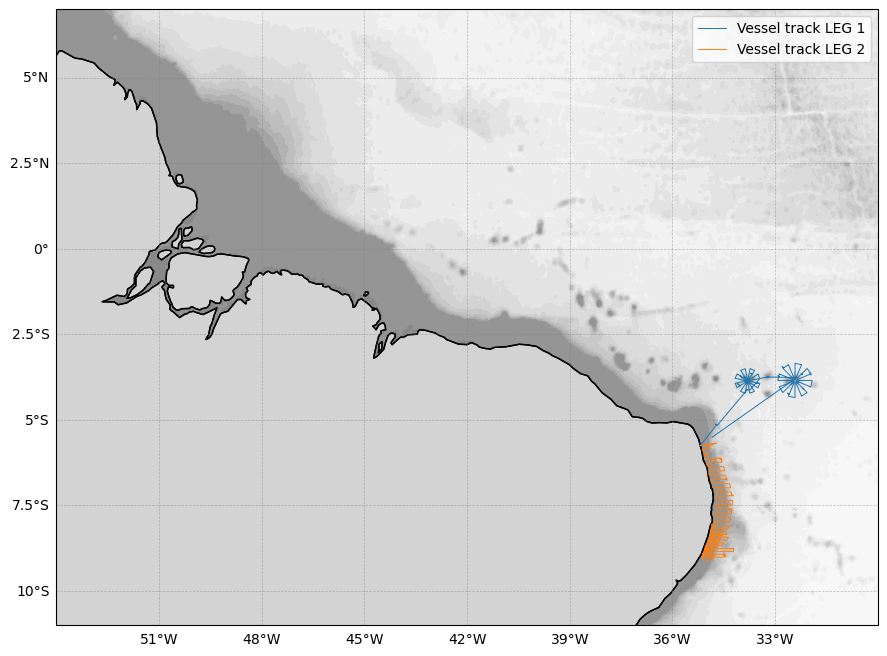

In [3]:
# Plot map of the survey
img_file = f"output/figures/{SURVEY}_survey_map.png"
if not os.path.isfile(img_file) or FORCE_PLOT:
    plot_survey_map(ds, outfile=img_file)
img = Image.open(img_file)
img

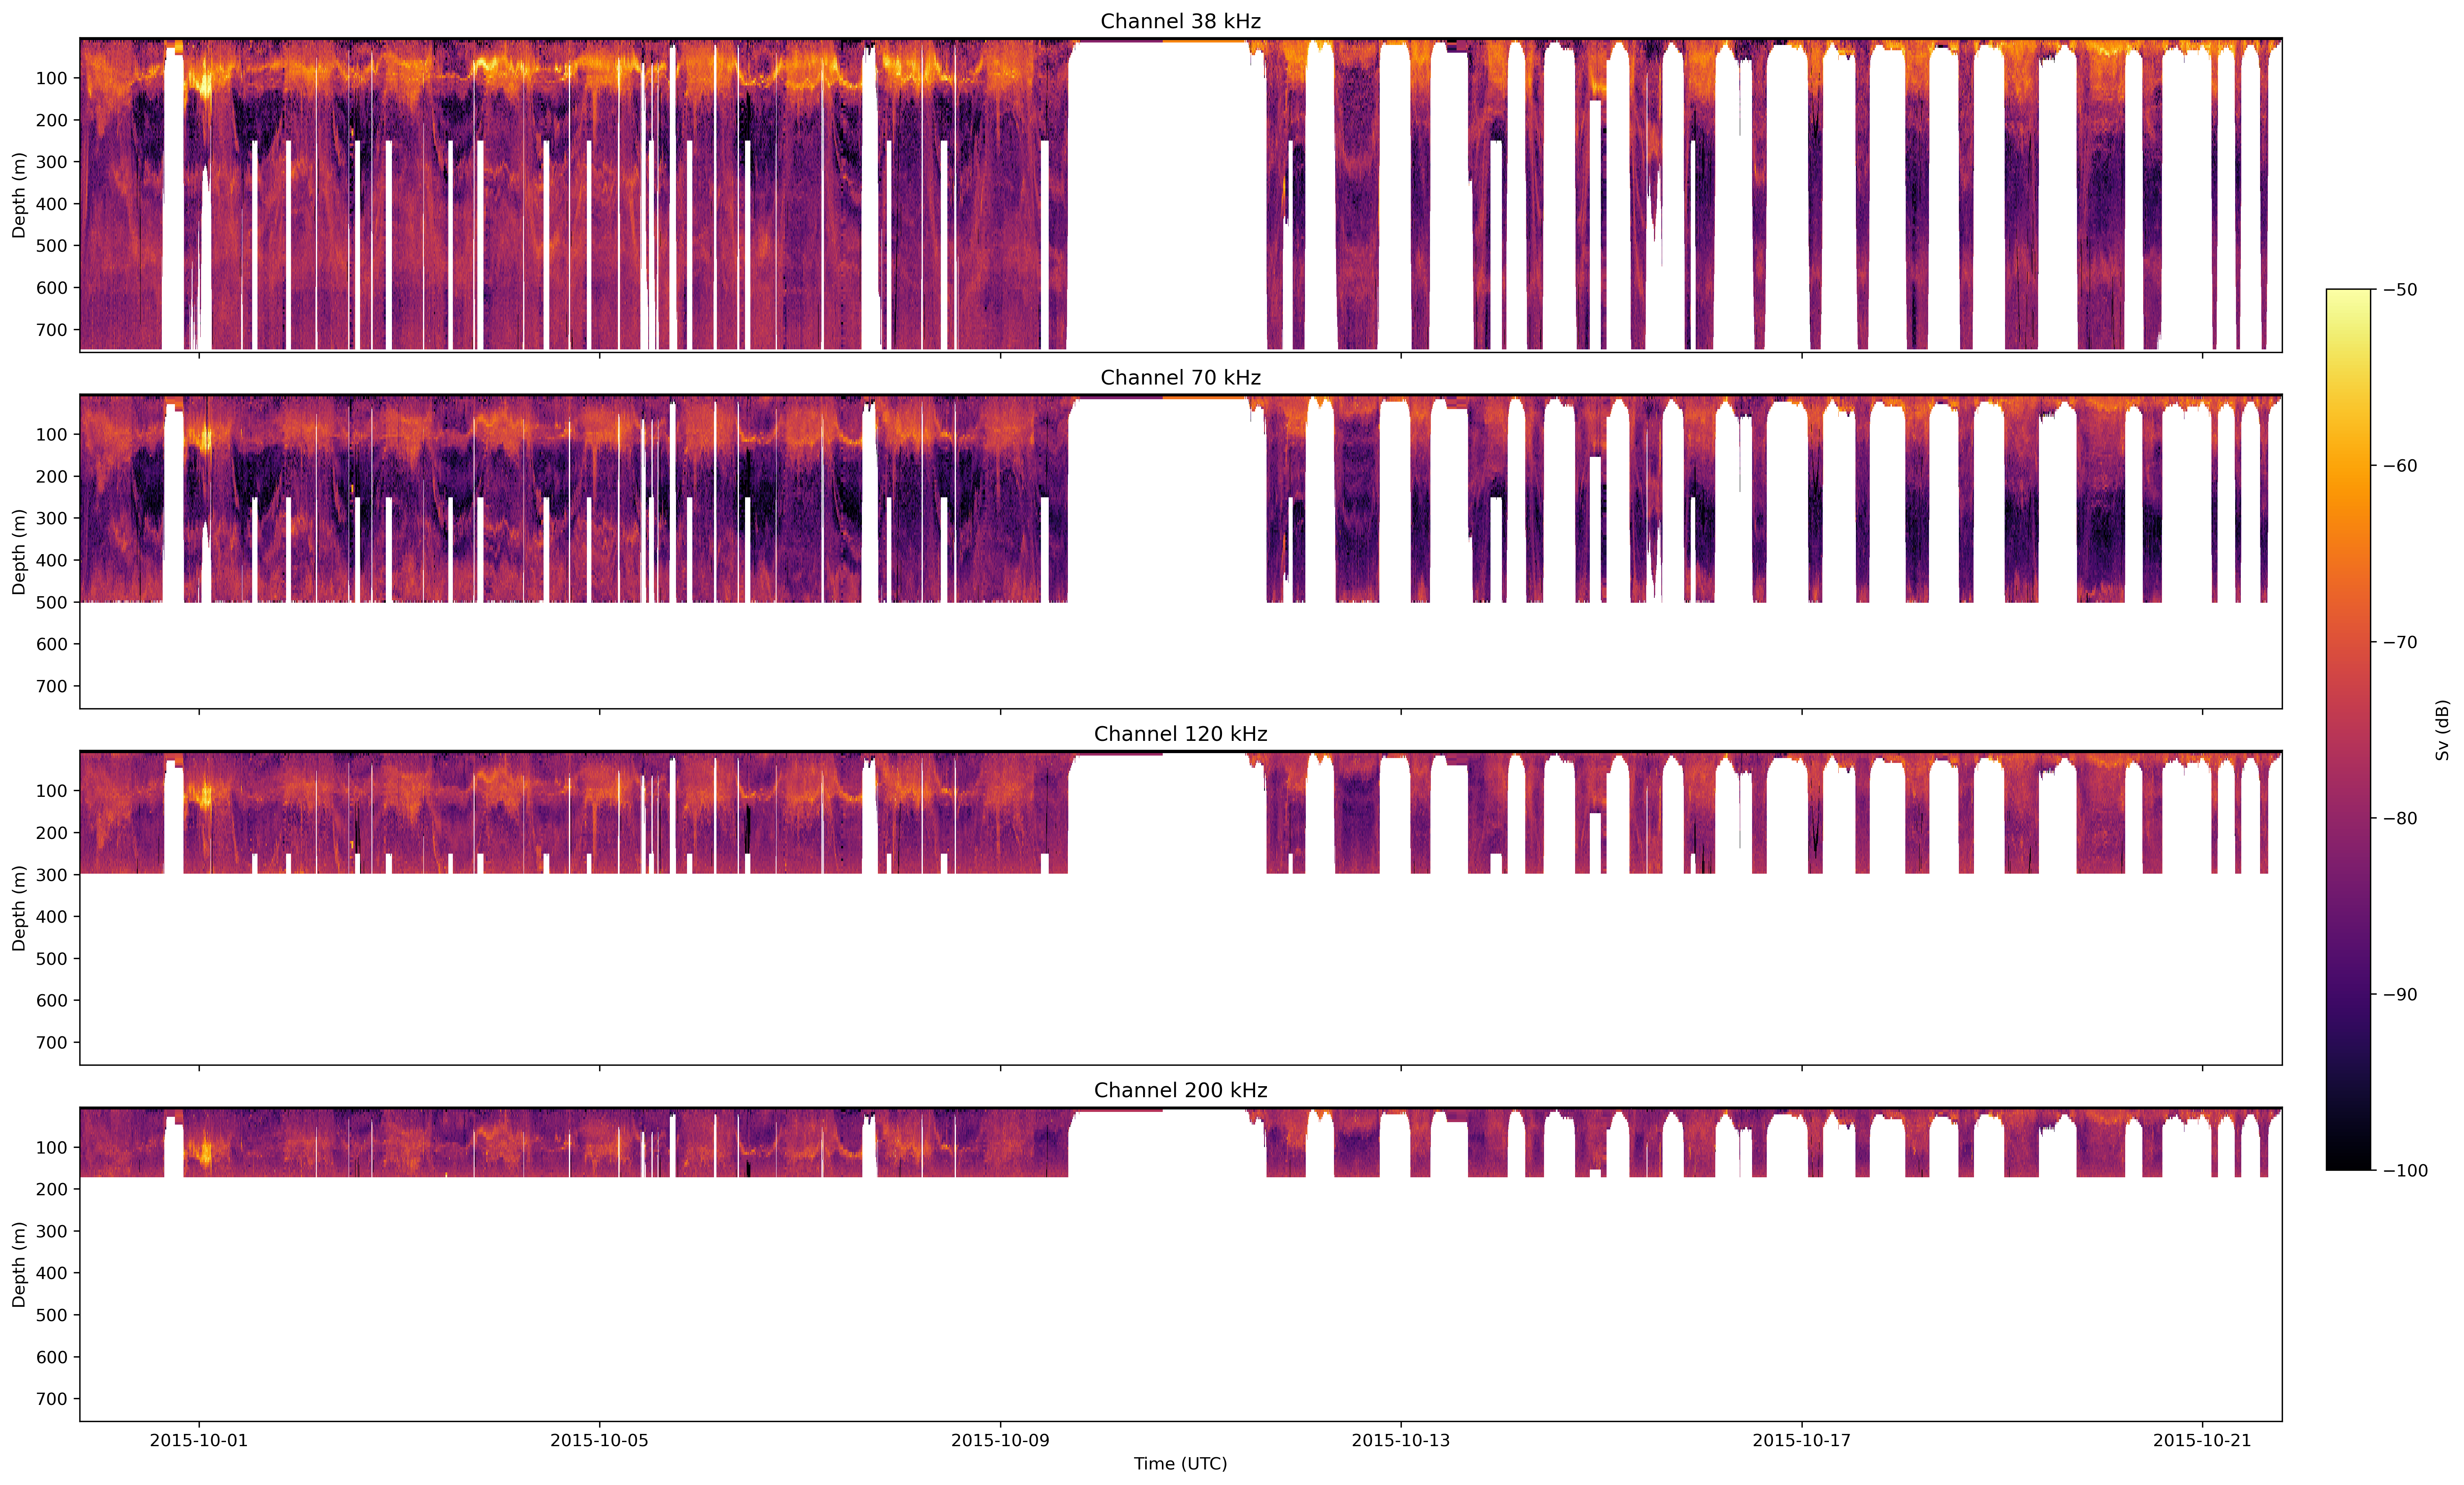

In [4]:
outfile = f"output/figures/{SURVEY}_4Cfacet.png"
if not os.path.isfile(outfile) or FORCE_PLOT:
    plot_sv_channels_faceted(
        ds["Sv"],
        outfile=outfile,
        cmap="inferno",
        figsize=(20, 12),
        vmin=-100,
        vmax=-50,
        sample_pixels=10_000_000
    )
img = Image.open(outfile)
img

# Show Sv distributions

In [5]:
FORCE_PLOT = True

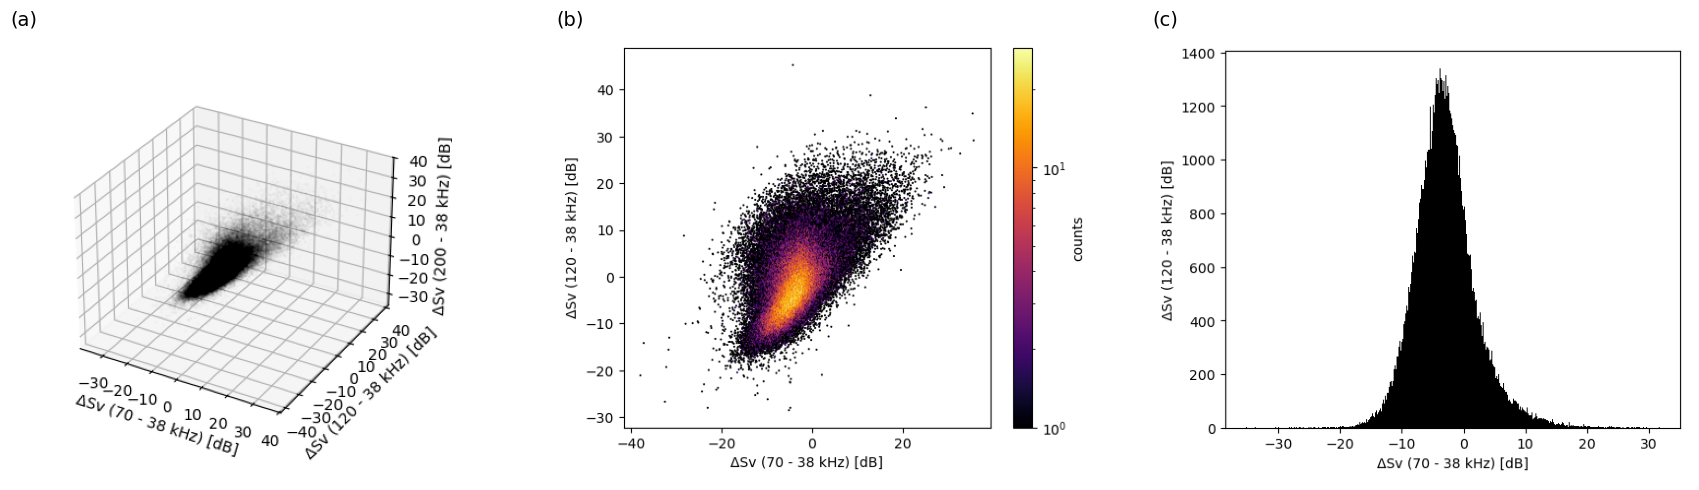

In [ ]:
FIGSIZE = (6, 5)

# 3D scatterplot in the 0 - 200 m depth range
sv = ds_to_sv(ds, sv_threshold=SV_THRESHOLD)
sv = filter_depth(sv, max_depth=200)
sv_diffs = compute_differences(sv, ch_ref=38, ch_list=[70, 120, 200])
flats = flatten_valid(*sv_diffs.values())
samples = sample_safe(*flats, n_samples=N_SAMPLES)

outfile = f"output/figures/{SURVEY}_SvDiffDist_3D0-200m_thresh{SV_THRESHOLD}_N{N_SAMPLES}.png"
if not os.path.isfile(outfile) or FORCE_PLOT:
    plot_3d_scatter(samples[0], samples[1], samples[2],
                    outfile=outfile,
                    figsize=FIGSIZE)

img_0 = Image.open(outfile)

# 2D hexbin plot in the 0 - 500 m depth range
sv = ds_to_sv(ds, sv_threshold=SV_THRESHOLD)
sv = filter_depth(sv, max_depth=500)
sv_diffs = compute_differences(sv, ch_ref=38, ch_list=[70, 120])
flats = flatten_valid(*sv_diffs.values())
samples = sample_safe(*flats, n_samples=N_SAMPLES)

outfile = f"output/figures/{SURVEY}_SvDiffDist_2D0-500m_thresh{SV_THRESHOLD}_N{N_SAMPLES}.png"
if not os.path.isfile(outfile) or FORCE_PLOT:
    plot_hexbin_2d(samples[0], samples[1],
                    outfile=outfile,
                    figsize=FIGSIZE)

img_1 = Image.open(outfile)

# 1D histogram in the 0 - 1000 m range
sv = ds_to_sv(ds, sv_threshold=SV_THRESHOLD)
sv = filter_depth(sv, max_depth=1000)
sv_diffs = compute_differences(sv, ch_ref=38, ch_list=[70])
flats = flatten_valid(*sv_diffs.values())
samples = sample_safe(*flats, n_samples=N_SAMPLES)

outfile = f"output/figures/{SURVEY}_SvDiffDist_1D0-1000m_thresh{SV_THRESHOLD}_N{N_SAMPLES}.png"
if not os.path.isfile(outfile) or FORCE_PLOT:
    plot_hist(samples[0],
              outfile=outfile,
              figsize=FIGSIZE)

img_2 = Image.open(outfile)


# Create a row of 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

images = [img_0, img_1, img_2]
labels = ['(a)', '(b)', '(c)']

for ax, img, label in zip(axes, images, labels):
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(label, loc='left', fontsize=14, pad=10)

plt.tight_layout()

combined_outfile = f"output/figures/{SURVEY}_SvDiffDist_combined.png"
plt.savefig(combined_outfile, dpi=300)
plt.show()